## 1D offshore spectrum to nearshore SWAN model

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

### Read in 1d Spectrum

The one dimensional spectrum is stored per timestep in the dataframe, the frequencies don't change.

In [3]:
oneD_Off = pd.read_csv('../data/spec1D_offshore.csv', header = 0, index_col = 0, parse_dates = True)
oneD_Off = oneD_Off.apply(pd.to_numeric, errors='coerce')

<Axes: >

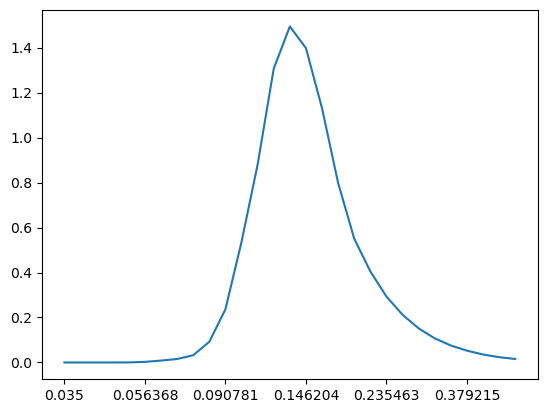

In [4]:
oneD_Off.iloc[0].plot()

We also need to ensure that we have some understanding of direction, so we will read in the offshore wave parameters.

In [5]:
offStats = pd.read_csv("../data/stats_offshore.csv", index_col = 0 , parse_dates =True )
offStats = offStats.apply(pd.to_numeric, errors='coerce')

In [6]:
offStats = offStats.drop(['lat', 'lon'], axis=1)

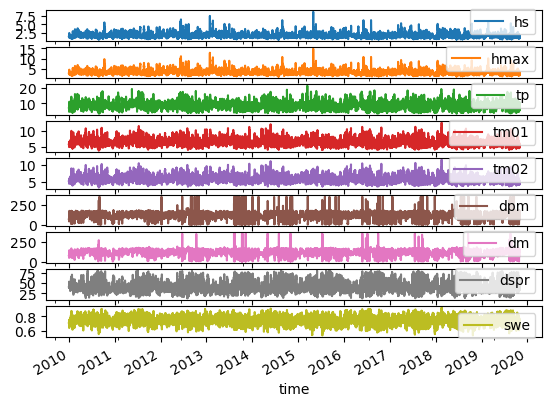

In [7]:
_ = offStats.plot(subplots = True)

## Read in our target data

We are going to target some nearshore wave parameters.

In [8]:
GCStats = pd.read_csv("../data/stats_GC.csv", index_col = 0 , parse_dates =True )
GCStats = GCStats.apply(pd.to_numeric, errors='coerce')
GCStats = GCStats.drop(['site'], axis=1)

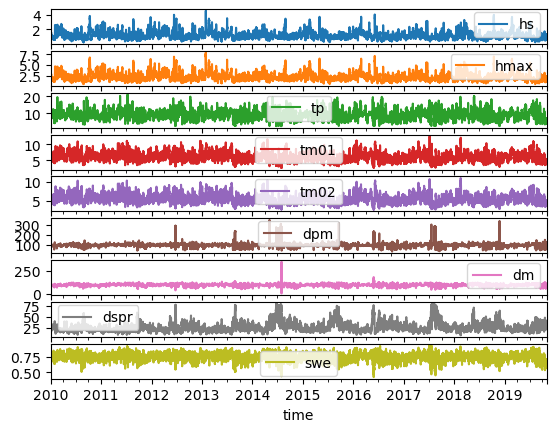

In [9]:
_ = GCStats.plot(subplots = True)

In [10]:
new_columns = [column + '_tgt' for column in GCStats.columns]
GCStats = GCStats.rename(columns=dict(zip(GCStats.columns, new_columns)))

## Merge our data where there are overlaps

In [11]:
merged_df = pd.merge(oneD_Off, offStats, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, GCStats, left_index=True, right_index=True)

## Feature engineering

We need to undertake some feature engineering to maintain time continuity and ensure that directional data is properly encoded.

In [12]:
merged_df.head()

,0.035,0.0385,0.04235,0.046585,0.051244,0.056368,0.062005,0.068205,0.075026,0.082528,...,swe,hs_tgt,hmax_tgt,tp_tgt,tm01_tgt,tm02_tgt,dpm_tgt,dm_tgt,dspr_tgt,swe_tgt
2010-01-01 00:00:00,0.0,0.0,0.0,0.0,0.000305,0.002664,0.008489,0.015421,0.032206,0.092174,...,0.702720,1.231773,2.215352,7.695021,6.008552,5.585557,81.387130,81.344312,22.721832,0.702076
2010-01-01 02:00:00,0.0,0.0,0.0,0.0,0.000209,0.002149,0.007587,0.015431,0.034824,0.089762,...,0.704869,1.228834,2.215275,7.675863,5.887595,5.415151,82.313896,81.665186,22.419107,0.727201
2010-01-01 03:00:00,0.0,0.0,0.0,0.0,0.000180,0.001918,0.007131,0.015327,0.036638,0.089586,...,0.703232,1.235995,2.231501,7.678613,5.799396,5.309187,82.791855,81.649424,22.368051,0.732569
2010-01-01 05:00:00,0.0,0.0,0.0,0.0,0.000122,0.001611,0.006111,0.014746,0.040239,0.091256,...,0.699899,1.257867,2.273790,7.697777,5.714181,5.224169,83.367165,81.323258,22.500365,0.729976
2010-01-01 06:00:00,0.0,0.0,0.0,0.0,0.000103,0.001522,0.005592,0.014315,0.041695,0.092745,...,0.699814,1.268362,2.292762,7.700089,5.708382,5.222059,83.398080,81.053785,22.670642,0.728691


**Time Based**

In [13]:
def feature_engineering_time_series(data):
    # Extracting features from the DateTimeIndex
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Adding cyclic timing features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Additional feature engineering steps can be added here
    
    return data

In [14]:
merged_df = feature_engineering_time_series(merged_df)

**Direction Based**

In [15]:
def feature_engineering_wave_direction(data, direction_columns):
    for column in direction_columns:
        # Creating circular features for wave direction
        data[f'{column}_sin'] = np.sin(np.radians(data[column]))
        data[f'{column}_cos'] = np.cos(np.radians(data[column]))
        
        # Removing the original column
        data.drop(column, axis=1, inplace=True)
    
    
    return data

In [16]:
dpm_col = list(merged_df.columns[merged_df.columns.str.contains('dpm')])
dm_col = list(merged_df.columns[merged_df.columns.str.contains('dm')])


In [17]:
merged_df = feature_engineering_wave_direction(merged_df, dpm_col + dm_col)

## Keep some data independent

In [18]:
ind_data = merged_df["2019-06-01":]
merged_df  = merged_df[:"2019-06-01"]

## Selecting Data for training

In [19]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dspr', 'swe', 'hs_tgt', 'hmax_tgt', 'tp_tgt',
       'tm01_tgt', 'tm02_tgt', 'dspr_tgt', 'swe_tgt', 'year', 'month', 'day',
       'day_of_week', 'hour', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'dpm_sin', 'dpm_cos',
       'dpm_tgt_sin', 'dpm_tgt_cos', 'dm_sin', 'dm_cos', 'dm_tgt_sin',
       'dm_tgt_cos'],
      dtype='object')

In [20]:
features_col = ['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735',
       'dm_sin', 'dm_cos',
       'month', 'day', 'hour']

In [21]:
labels_col = ['hs_tgt']

In [22]:
features = merged_df[features_col]
labels = merged_df[labels_col]

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [24]:
from sklearn.model_selection import TimeSeriesSplit

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [26]:
norm_f = MinMaxScaler().fit(features)
X_train = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels)
y_train = norm_l.transform(labels)

## Training

In [27]:
from sklearn.neural_network import MLPRegressor
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [28]:
X_train.shape[0]/2*(X_train.shape[1]+1)

962920.0

In [29]:
100**4

100000000

#### Training on a sub set

We train on a subset to help identify the best model parameters to use.

In [30]:
def find_best_model(features, labels, sample_size=10000):
    # Randomly sample a subset of the data
    sampled_features, sampled_labels = resample(features, labels, n_samples=sample_size, random_state=42)
    
    # Define the parameter grid for grid search
    param_grid = {
        'hidden_layer_sizes': [(50,), (50, 50), (10, 10), (10, 10, 10), (100, 100, 100), (100,100,100,100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
    }
    
    # Create the MLPRegressor model
    model = MLPRegressor(random_state=42)
    
    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(sampled_features, sampled_labels)
    
    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    return best_model, best_params

In [31]:
best_model, best_params = find_best_model(features, labels, sample_size=2000)

# Print the best model and best parameters
print("Best Model:")
print(best_model)
print("\nBest Parameters:")
print(best_params)

/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_n

Best Model:
MLPRegressor(alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100),
             random_state=42)

Best Parameters:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100, 100, 100), 'solver': 'adam'}


In [32]:
clf_mlp1 = MLPRegressor(hidden_layer_sizes = best_params['hidden_layer_sizes'],
                                             activation = best_params['activation'],
                                             solver = best_params['solver'],
                                             shuffle = False,
                                             early_stopping = False,
                                             random_state = 0,
                                             alpha =  best_params['alpha'])

clf_mlp2 = MLPRegressor(hidden_layer_sizes = (100, 100, 100, 100),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0,
                                             alpha =  0.001)

In [33]:
tscv = TimeSeriesSplit(n_splits=int(len(X_train)//13), test_size = 2)

**Train via time series method**

In [34]:
#for train_index, test_index in tscv.split(X_train):
#    X__train_stream, X_test_stream = X_train[train_index, :], y_train[train_index, :]
#    clf_mlp1.partial_fit(X__train_stream, X_test_stream.ravel())

**Train via normal method**

In [35]:
clf_mlp2.fit(X_train, y_train)

/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(alpha=0.001, early_stopping=True,
             hidden_layer_sizes=(100, 100, 100, 100), random_state=0,
             shuffle=False)

## Make a prediction (single parameter)

In [36]:
import matplotlib.pyplot as plt

In [37]:
hs_pred = norm_l.inverse_transform(pd.Series(clf_mlp2.predict(norm_f.transform(ind_data[features_col]))).values.reshape(-1,1))

In [38]:
prediction = pd.DataFrame(hs_pred, index = ind_data.index, columns = ['hs_tgt'])

<Axes: >

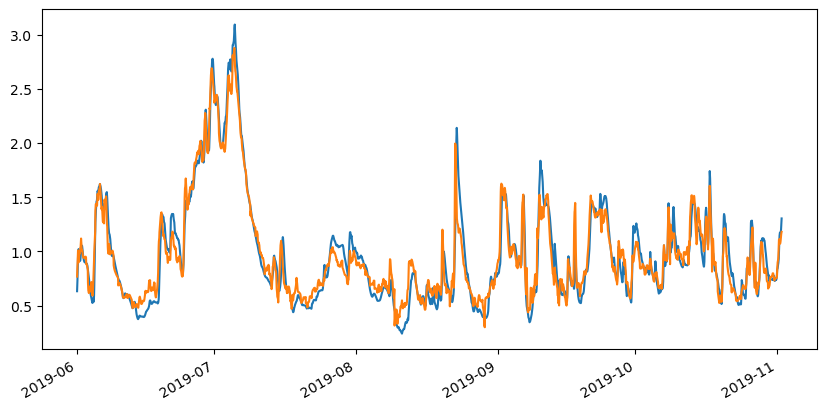

In [39]:
plt.figure(figsize = (10, 5))
ind_data.hs_tgt.plot()
prediction.hs_tgt.plot()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compare_columns(df1, df2):
    matching_columns = set(df1.columns) & set(df2.columns)
    results = pd.DataFrame(columns=['Column', 'RMSE', 'MSE', 'Bias', 'Correlation'])
    
    for column in matching_columns:
        values1 = df1[column].values
        values2 = df2[column].values
        
        rmse = np.sqrt(mean_squared_error(values1, values2))
        mse = mean_squared_error(values1, values2)
        bias = np.mean(values1 - values2)
        correlation = np.corrcoef(values1, values2)[0, 1]
        
        results = results.append({
            'Column': column,
            'RMSE': rmse,
            'MSE': mse,
            'Bias': bias,
            'Correlation': correlation
        }, ignore_index=True)
    
    return results

In [41]:
compare_columns(ind_data, prediction)

/tmp/ipykernel_1778/4055570356.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


,Column,RMSE,MSE,Bias,Correlation
0,hs_tgt,0.134677,0.018138,-0.002965,0.962972


## Try the same model using Deep Learning

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Convert features and labels to PyTorch tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(labels.values, dtype=torch.float32)

# Normalize the features and labels
norm_f = MinMaxScaler().fit(features)
X = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels)
y = norm_l.transform(labels)

# Split the data into training and testing sets
test_size = 0.2
train_size = int((1 - test_size) * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model in PyTorch
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Define the function to create sequences from the input data
def create_sequences(features, labels, sequence_length):
    seq_features, seq_labels = [], []
    for i in range(len(features) - sequence_length + 1):
        seq_features.append(features[i:i+sequence_length])
        seq_labels.append(labels[i+sequence_length-1])
    return torch.tensor(seq_features, dtype=torch.float32), torch.tensor(seq_labels, dtype=torch.float32)

# Create sequences from the input data
sequence_length = len(X_train)//12  # Adjust this value based on your desired sequence length
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Define the hyperparameters
input_size = X_train_seq.shape[2]  # Number of input features
output_size = y_train_seq.shape[1]
num_epochs = 100
hidden_size = 64
learning_rate = 0.001 

# Create the LSTM model
model = LSTM(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_seq)
    loss = criterion(outputs, y_train_seq)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

: 

: 

In [ ]:
# Convert the test data to PyTorch tensor and create sequences
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Set the model in evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    # Forward pass on the test data
    test_outputs = model(X_test_seq)

# Denormalize the predicted outputs
test_outputs = norm_l.inverse_transform(test_outputs)

# Print the predicted outputs
print("Predicted Outputs:")
print(test_outputs)

Predicted Outputs:
[[0.91964574]
 [0.93215862]
 [0.95123602]
 ...
 [1.21862038]
 [1.21251383]
 [1.19773479]]


In [57]:
prediction_DL = pd.DataFrame(test_outputs, index = ind_data.index, columns = ['hs_tgt'])

ValueError: Shape of passed values is (10994, 1), indices imply (2464, 1)

## Multi-parameter model

Attempt to fit a multiparameter model so that we can predict the full set of parameters

In [166]:
labels_col = ['hs_tgt', 'hmax_tgt', 'tp_tgt','tm01_tgt', 'tm02_tgt', 'swe_tgt','dm_sin', 'dm_cos']

In [179]:
features = merged_df[features_col]
labels = merged_df[labels_col]
labels = labels.interpolate(method='linear', axis=0)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [182]:
norm_f = MinMaxScaler().fit(features)
X_train = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels)
y_train = norm_l.transform(labels)

In [183]:
best_model, best_params = find_best_model(features, labels, sample_size=2000)

# Print the best model and best parameters
print("Best Model:")
print(best_model)
print("\nBest Parameters:")
print(best_params)

/home/lpeach/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lpeach/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lpeach/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lpeach/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

Best Model:
MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 100, 100),
             random_state=42)

Best Parameters:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'solver': 'adam'}


/home/lpeach/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [184]:
clf_mlp3 = MLPRegressor(hidden_layer_sizes = best_params['hidden_layer_sizes'],
                                             activation = best_params['activation'],
                                             solver = best_params['solver'],
                                             shuffle = False,
                                             early_stopping = False,
                                             random_state = 0,
                                             alpha =  best_params['alpha'])

In [185]:
clf_mlp3.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 100, 100),
             random_state=0, shuffle=False)

In [191]:
pred = norm_l.inverse_transform(pd.DataFrame(clf_mlp3.predict(norm_f.transform(ind_data[features_col]))))

In [194]:
predictions = pd.DataFrame(pred, index = ind_data.index, columns = labels_col)

In [205]:
def plot_matching_columns(df1, df2):
    matching_columns = set(df1.columns) & set(df2.columns)
    
    for column in matching_columns:
        plt.figure(figsize = (10,5))
        plt.plot(df1[column], label='SWAN')
        plt.plot(df2[column], label='Prediction')
        plt.title(column)
        plt.legend()
        plt.show()

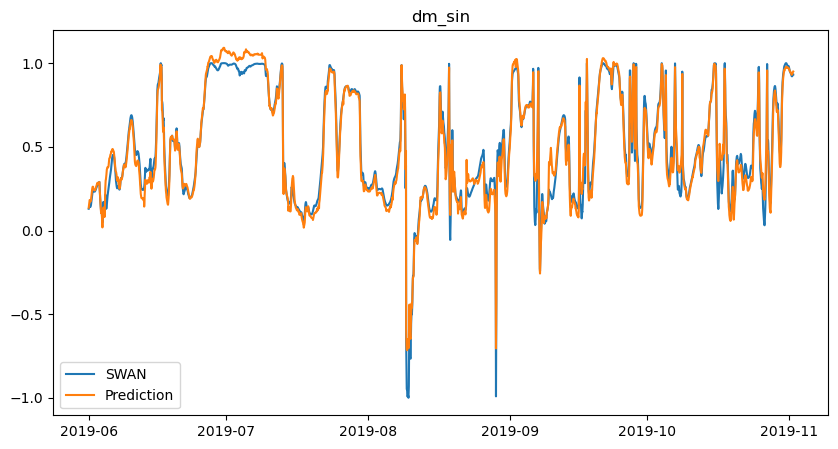

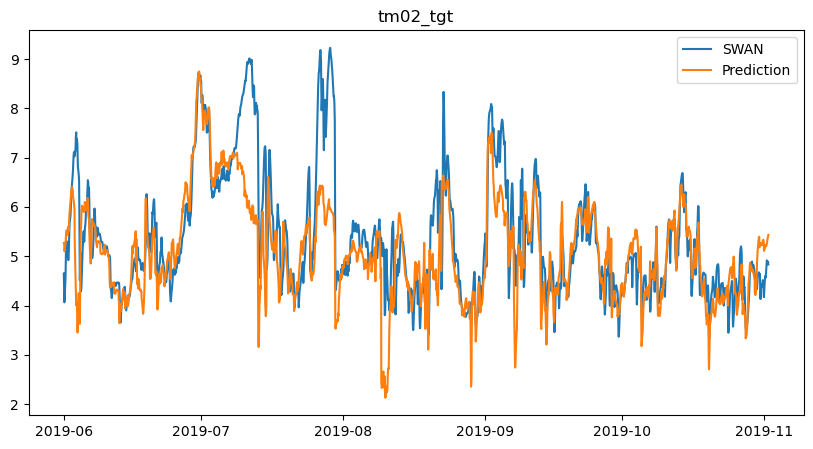

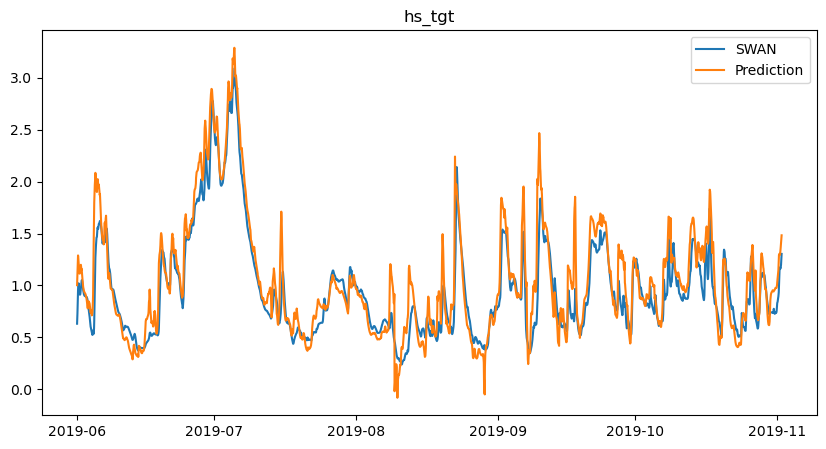

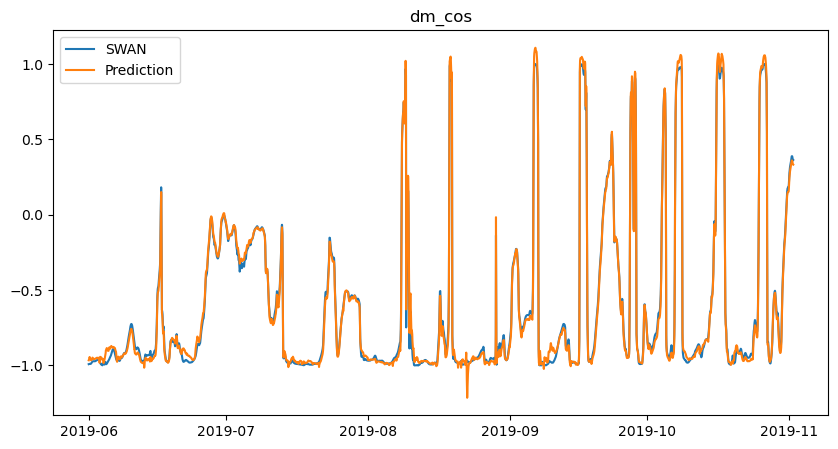

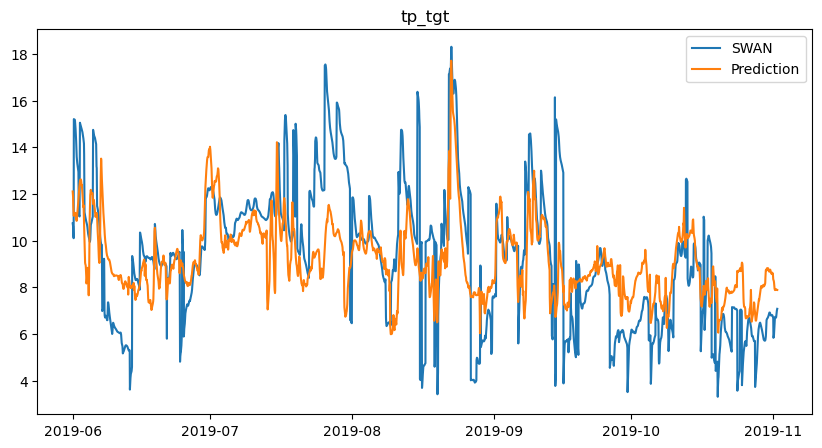

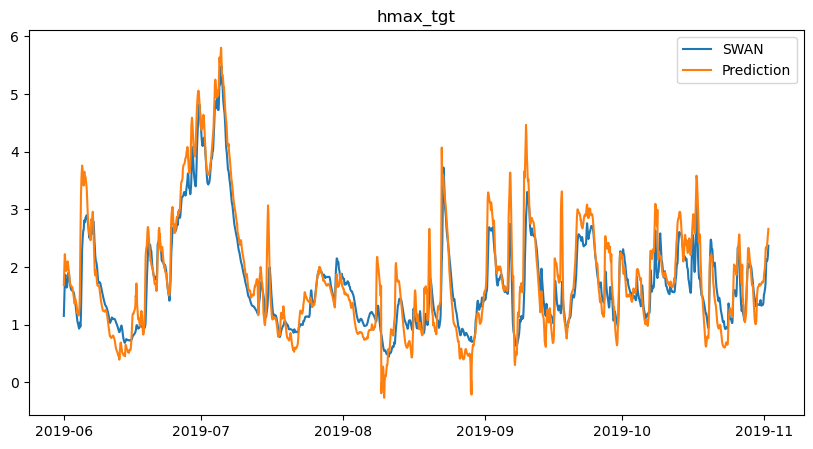

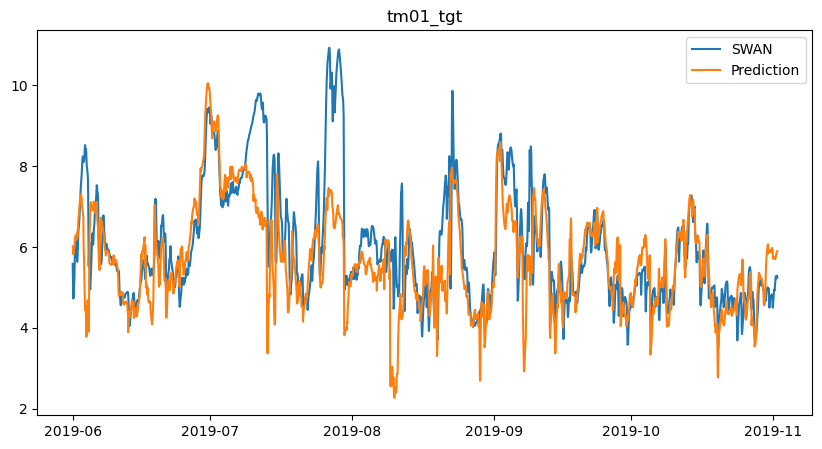

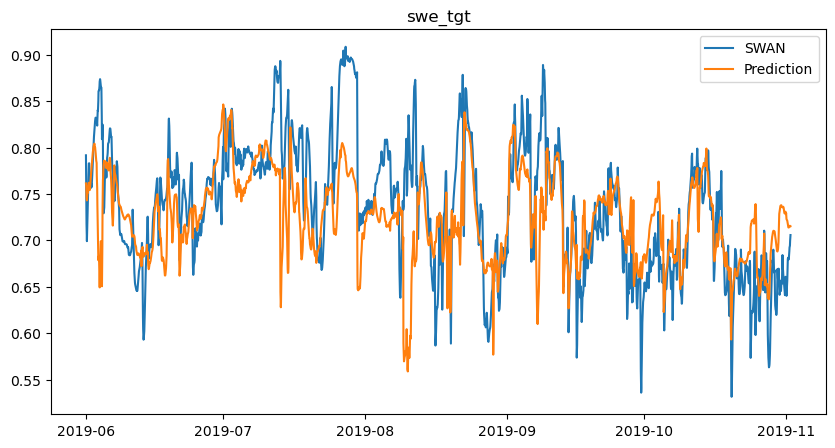

In [206]:
plot_matching_columns(ind_data, predictions)

In [211]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compare_columns(df1, df2):
    matching_columns = set(df1.columns) & set(df2.columns)
    results = pd.DataFrame(columns=['Column', 'RMSE', 'MSE', 'Bias', 'Correlation'])
    
    for column in matching_columns:
        values1 = df1[column].values
        values2 = df2[column].values
        
        rmse = np.sqrt(mean_squared_error(values1, values2))
        mse = mean_squared_error(values1, values2)
        bias = np.mean(values1 - values2)
        correlation = np.corrcoef(values1, values2)[0, 1]
        
        results = results.append({
            'Column': column,
            'RMSE': rmse,
            'MSE': mse,
            'Bias': bias,
            'Correlation': correlation
        }, ignore_index=True)
    
    return results

In [212]:
compare_columns(ind_data, predictions)

/tmp/ipykernel_387/2498596622.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_387/2498596622.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_387/2498596622.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_387/2498596622.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_387/2498596622.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/

,Column,RMSE,MSE,Bias,Correlation
0,dm_sin,0.059036,0.003485,0.003306,0.984112
1,tm02_tgt,0.857332,0.735018,0.262063,0.754131
2,hs_tgt,0.212356,0.045095,-0.086317,0.940492
3,dm_cos,0.031394,0.000986,-0.000604,0.998323
4,tp_tgt,2.234220,4.991739,0.131865,0.660630
5,hmax_tgt,0.393734,0.155027,-0.099604,0.935687
6,tm01_tgt,1.080267,1.166976,0.333684,0.725153
7,swe_tgt,0.057862,0.003348,0.011526,0.583582
